In [1]:
#Dataset Link - https://www.eeoc.gov/statistics/employment/jobpatterns/eeo1

############################# IMPORTS ############################

import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
from pandas.plotting import table
import re
import matplotlib as mpl

In [2]:
############################# CONSTANTS ############################

COLUMN_MAPPING_FILE = "ColumnHeaderInformation.csv"
EE01_DATASET_2017 = "DiversityDataset2017.csv"
EE01_DATASET_2018 = "DiversityDataset2018.csv"
DATASETS = [EE01_DATASET_2017, EE01_DATASET_2018]
COLUMN_AGGREGATE_ALL = 'TOTAL10'
COMPARISIONS = ["NAICS2_Name", "Region", "State"]
STR_HEADER_COLUMNS = ['Nation', 'Region', 'Division', 'State', 'CBSA','County', 'NAICS2_Name',
                'NAICS3_Name']
INDUSTRY_NAME="NAICS2_Name"
COMPARISIONS_TYPES = ['Race', 'Sex', 'Job']
FONT_TITLE_BAR=24
FONT_TITLE_LINE=20
FONTXAXIS=20
FONTYAXIS=20
FONTXLABEL=16
FONTYLABEL=18

In [3]:
############################# FUNCTIONS ############################

def getColumnMappingDict():
    input_file = csv.DictReader(open(COLUMN_MAPPING_FILE))
    column_mapping = {}
    for row in input_file:
        column_label_split = row['Column Label'].split(",")
        column_label = {}
        for label in column_label_split:
            label_split = label.split(":")
            column_label[label_split[0].strip()]=label_split[1].strip()
        column_mapping[row['Column Name'].strip()]=column_label
    return column_mapping

def getColumnHeadersWithParticularLabel(column_mapping, label_race, label_sex, label_job):
    column_headers = set()
    for key,value in column_mapping.items():
        if label_race!='' and label_sex!='' and label_job !='' :
            if value['Race'] == label_race and value['Sex']==label_sex and value['Job']==label_job :
                column_headers.add(key)
        elif label_race =='' and label_sex!='' and label_job !='':
            if value['Race'] != 'Aggregate' and value['Sex']==label_sex and value['Job']==label_job:
                column_headers.add(key)
        elif label_race !='' and label_sex =='' and label_job !='':
            if value['Race'] == label_race and value['Sex']!='Aggregate' and value['Job']==label_job:
                column_headers.add(key)
        elif label_race !='' and label_sex !='' and label_job =='':
            if value['Race'] == label_race and value['Sex']==label_sex and value['Job']!='Aggregate':
                column_headers.add(key)
        else:
            print('Wrong Input')
    return list(column_headers)

def getDataFrameFromCSV(dataset_name):
    df = pd.read_csv(dataset_name, encoding = "ISO-8859-1", engine='python')
    df.columns = df.columns.str.strip()
    column_list = list(df.columns)
    int_columns = [x for x in column_list if x not in STR_HEADER_COLUMNS]
    df[int_columns] = df[int_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    return df

def getRelevantColumns(df, column_list):
    #print("Using Columns from EE01 Dataset - ", column_list)
    df = df[column_list]
    df = replaceIndustryShortNames(df);
    return df

def plotBarChartForADataFrame(df, col_name_x, col_name_y, title, yLabel, xLabel):
    df=df.set_index(col_name_x)
    number_of_colors = 20
    mycolors = ["#"+''.join([random.choice('0123456789ABCDE') for j in range(6)])
             for i in range(number_of_colors)]
    plt.figure()
    plt.title(title,fontsize=FONT_TITLE_BAR,fontweight='bold')
    ax = plt.gca()
    ax.tick_params(axis='x', size=FONTXAXIS)
    ax.tick_params(axis='y', size=FONTYAXIS)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #labels = ax.get_xticklabels() + ax.get_yticklabels()
    #[label.set_fontweight('bold') for label in labels]
    df[col_name_y].plot(kind="bar",figsize=(12, 5),color=mycolors)
    plt.ylabel(yLabel,color="purple",fontsize=FONTXLABEL,fontweight='bold')
    plt.xlabel(xLabel,color="purple",fontsize=FONTYLABEL,fontweight='bold')

def defineDataset(column_mapping):
    set_race = set()
    set_sex = set()
    set_job = set()
    for key,value in column_mapping.items():
        set_race.add(value['Race'])
        set_sex.add(value['Sex'])
        set_job.add(value['Job'])
    return list(set_race), list(set_sex), list(set_job)

def plotLineGraphForADataFrame(df, column_grouped_by, column_headers,title, yLabel, xLabel):
    column_headers.remove(column_grouped_by)
    df.plot(x=column_grouped_by, y=column_headers,figsize=(15, 5))
    df=df.set_index(column_grouped_by)
    plt.title(title,fontsize=FONT_TITLE_LINE,fontweight='bold')
    plt.xticks(range(0,len(df.index)),df.index,rotation=90)
    plt.tick_params(axis='x', size=FONTXAXIS)
    plt.tick_params(axis='y', size=FONTYAXIS)
    plt.ylabel(yLabel,color="purple",fontsize=FONTXLABEL,fontweight='bold')
    plt.xlabel(xLabel,color="purple",fontsize=FONTYLABEL,fontweight='bold')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()
    
def DrawComparisionBetweenColumnsForADataFrame(df, column_headers, column_grouped_by, title):
    df=df.groupby(column_grouped_by, as_index=False)[column_headers].sum()
    shape = df.shape
    columns_list = list(df.columns)
    if(shape[1]==2):
        plotBarChartForADataFrame(df, columns_list[0], columns_list[1], title,"No of Employees","Industries")
    else:
        plotLineGraphForADataFrame(df, column_grouped_by, column_headers,title,"No of Employees","Industries")

def renameDataFrameMapping(df, column_mapping, mapping_to_take):
    column_list = df.columns
    new_column_list = []
    rename_mapping = {}
    for column in column_list:
        if column in column_mapping:
            rename_mapping[column]=column_mapping[column][mapping_to_take]
            new_column_list.append(column_mapping[column][mapping_to_take])
        else:
            rename_mapping[column]=column
            new_column_list.append(column)
    df=df.rename(columns = rename_mapping)
    return df,new_column_list

def getYearFromDataset(dataset):
    numbers = re.findall(r'\d+', dataset)
    if(len(numbers)>1):
        print("Dataset Nomenclature is incorrect")
    return str(numbers[0])
    
def getFunctionsForComparison(label_race,label_sex,label_job,mapping_to_take,title):
    column_headers = getColumnHeadersWithParticularLabel(column_mapping, label_race, label_sex, label_job)
    column_headers.append(INDUSTRY_NAME)
    df = getRelevantColumns(EE01_df, column_headers)
    df,column_headers = renameDataFrameMapping(df, column_mapping, mapping_to_take)
    DrawComparisionBetweenColumnsForADataFrame(df, column_headers, INDUSTRY_NAME, title)

def getHeaderMapping():
    header_mapping = {}
    for comparision in COMPARISIONS:
        if comparision == "NAICS2_Name" :
            header_mapping[comparision] = "Industry"
        else:
            header_mapping[comparision] = comparision
    for comparision in COMPARISIONS_TYPES:
        if comparision == "Sex" :
            header_mapping[comparision] = "Gender"
        else:
            header_mapping[comparision] = comparision
    return header_mapping

def replaceIndustryShortNames(df):
    industry_mapping = {}
    industry_mapping["Accommodation and Food Services"]="Accomodation and Food";
    industry_mapping["Agriculture, Forestry, Fishing and Hunting"]="Agriculture";
    industry_mapping["Administrative and Support and Waste Management and Remediation Services"]="Administrative";
    industry_mapping["Arts, Entertainment, and Recreation"]="Entertainment";
    industry_mapping["Educational Services"]="Education";
    industry_mapping["Finance and Insurance"]="Finance";
    industry_mapping["Health Care and Social Assistance"]="Health Care";
    industry_mapping["Management of Companies and Enterprises"]="Management";
    industry_mapping["Mining, Quarrying, and Oil and Gas Extraction"]="Mining and Oil Extraction";
    industry_mapping["Other Services (except Public Administration)"]="Other Services";
    industry_mapping["Professional, Scientific, and Technical Services"]="Scientific Community";
    industry_mapping["Real Estate and Rental and Leasing"]="Real Estate";
    industry_mapping["Retail Trade"]="Retail";
    industry_mapping["Wholesale Trade"]="Wholesale";   
    df = df.replace({INDUSTRY_NAME : industry_mapping});  
    return df;

In [4]:
############################# READ CSV #############################

column_mapping = getColumnMappingDict()
EE01_df_dict = {}
for dataset in DATASETS:
    EE01_df_dict[dataset]=getDataFrameFromCSV(dataset)

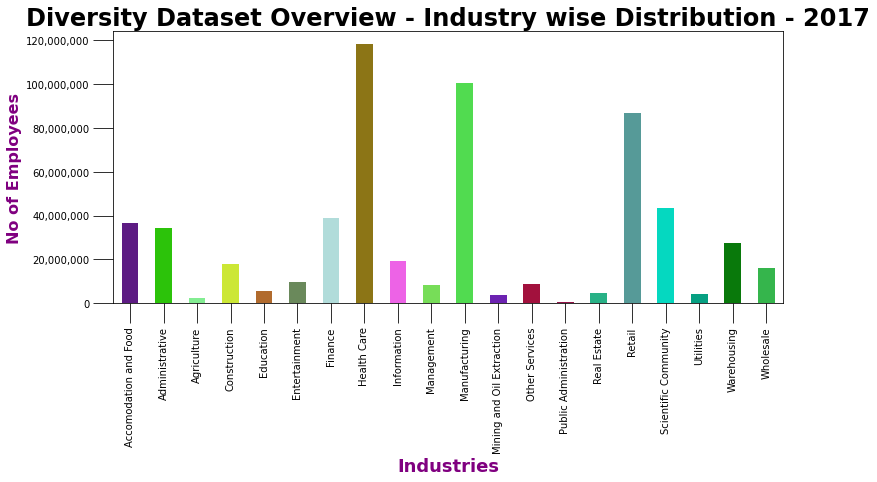

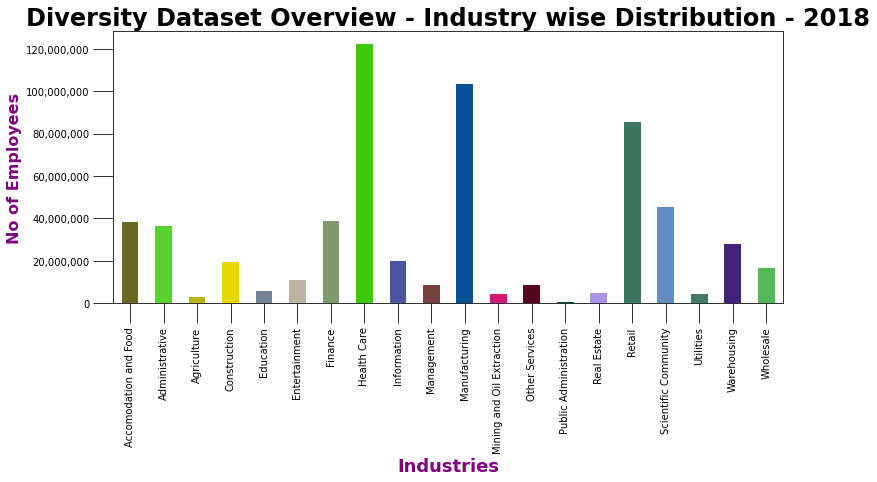

In [5]:
############## INDUSTRY WISE - AGGREGATE COMPARISION ###############

for dataset, EE01_df in EE01_df_dict.items():
    column_headers = getColumnHeadersWithParticularLabel(column_mapping, 'Aggregate', 'Aggregate', 'Aggregate')
    column_headers.append(INDUSTRY_NAME)
    df = getRelevantColumns(EE01_df, column_headers)
    DrawComparisionBetweenColumnsForADataFrame(df, column_headers, INDUSTRY_NAME, 'Diversity Dataset Overview - Industry wise Distribution - '+getYearFromDataset(dataset))

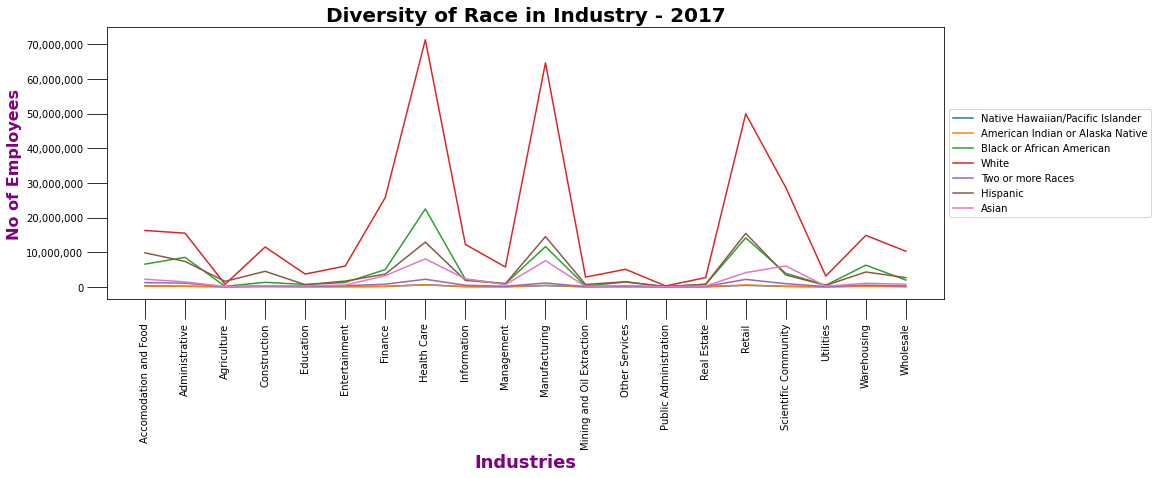

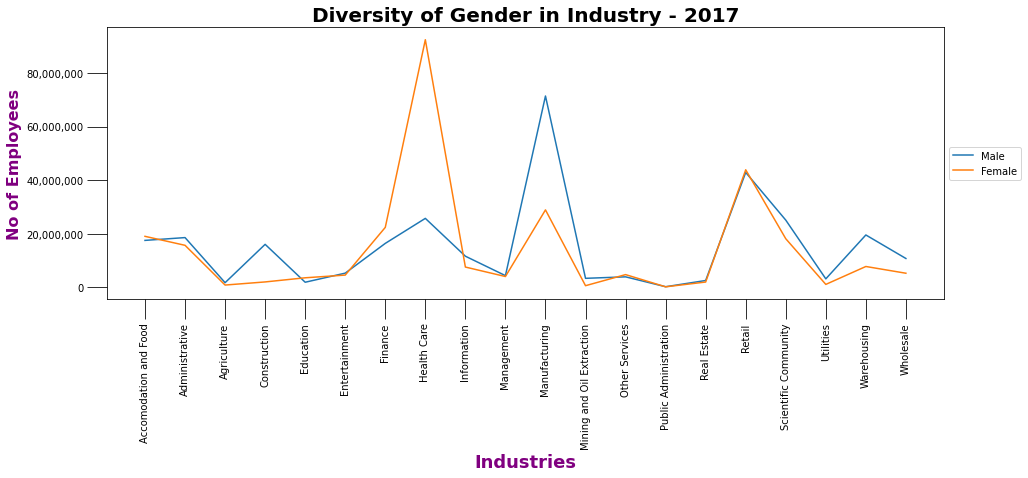

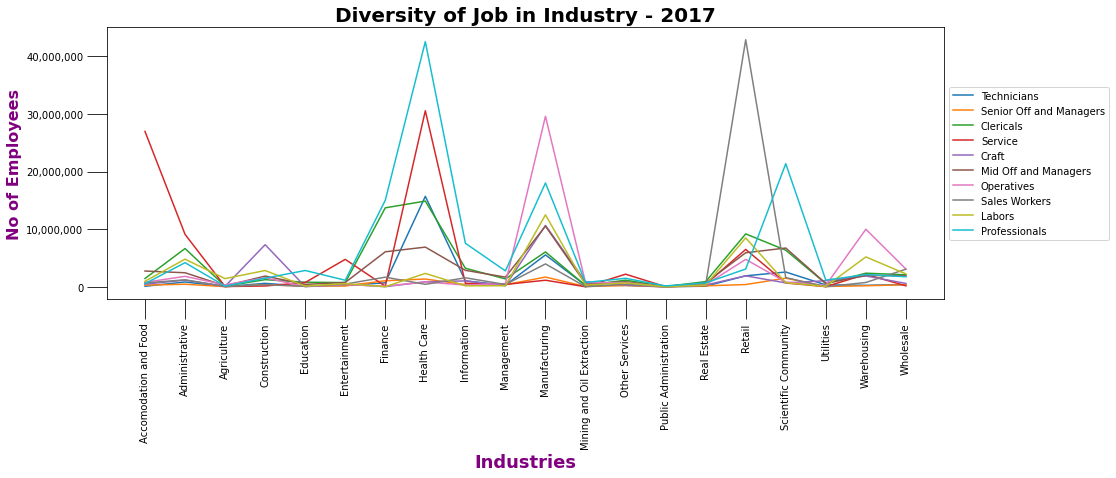

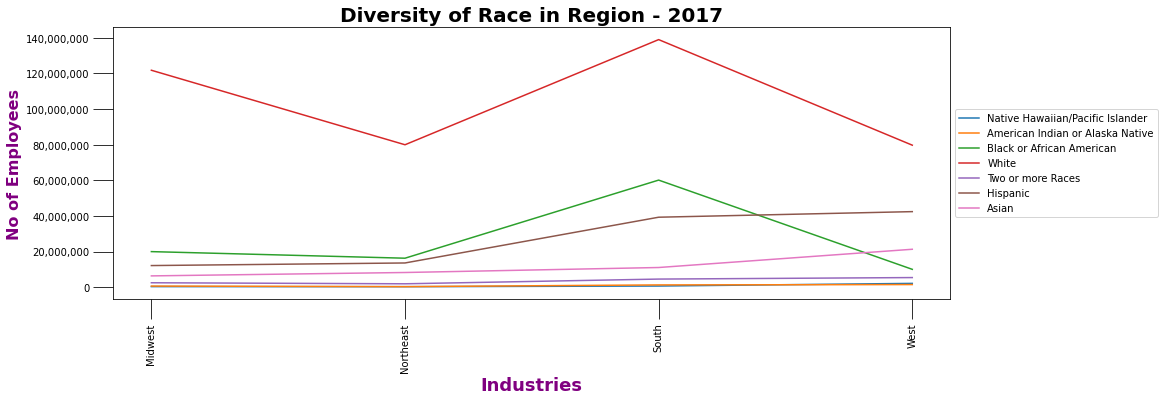

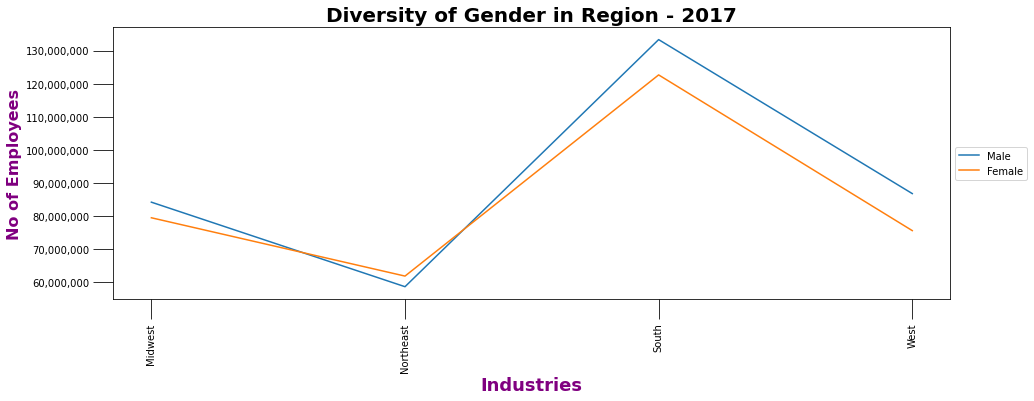

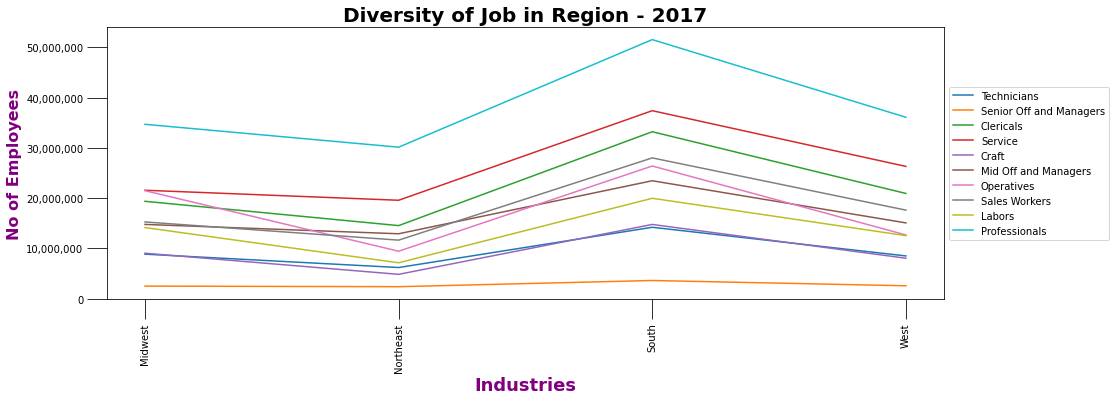

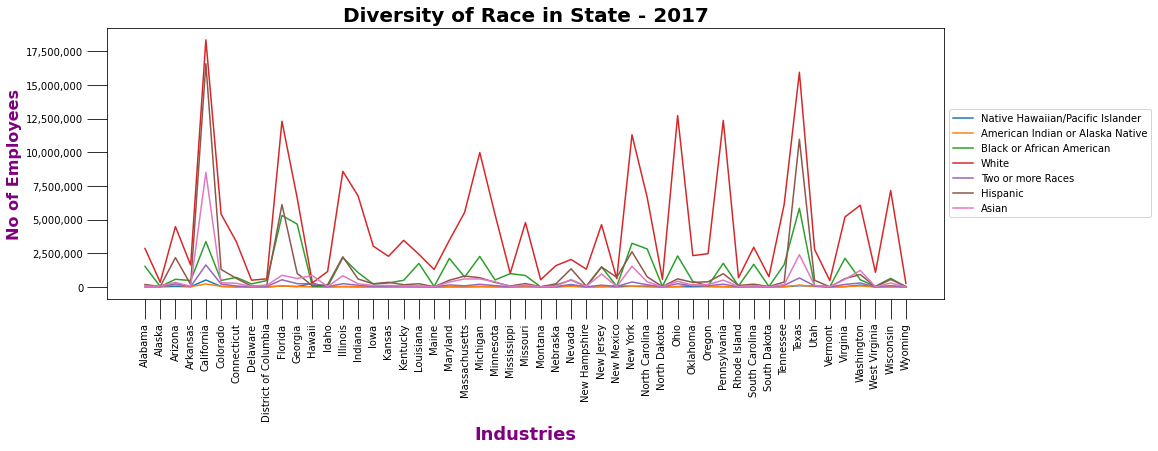

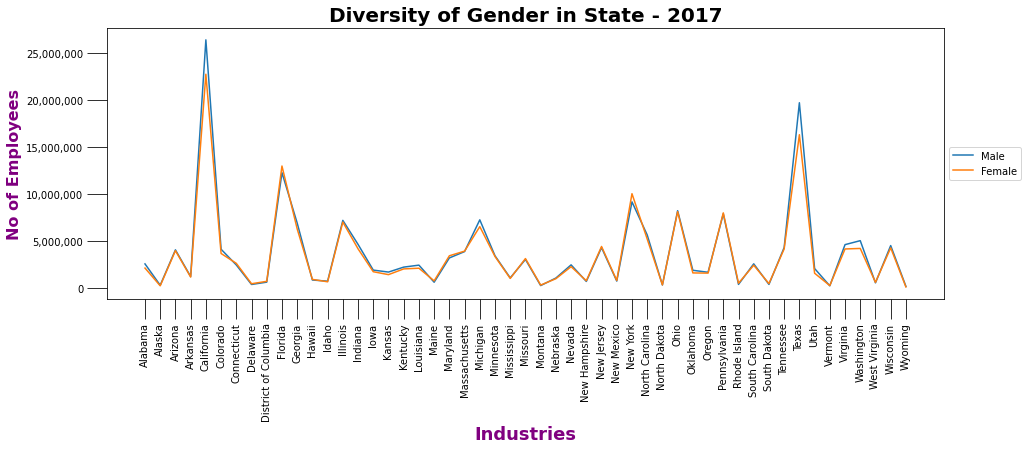

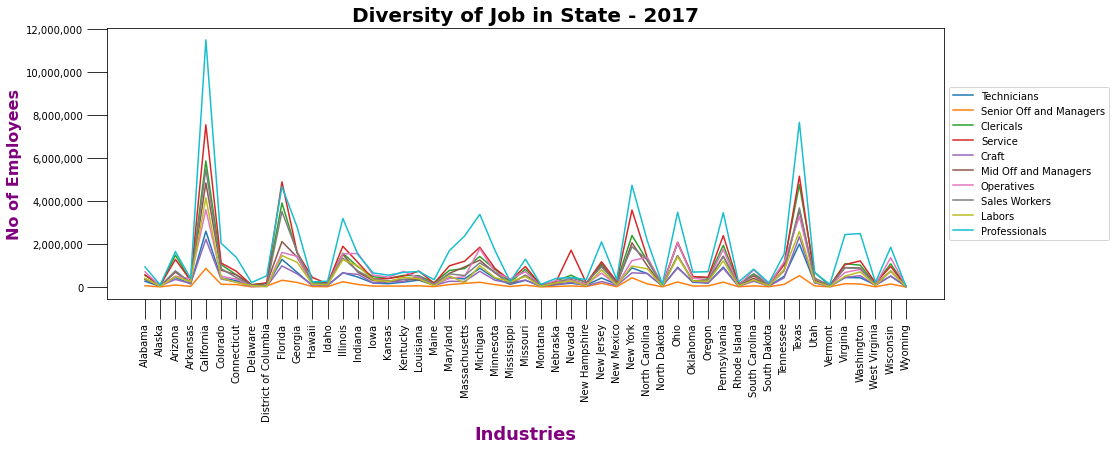

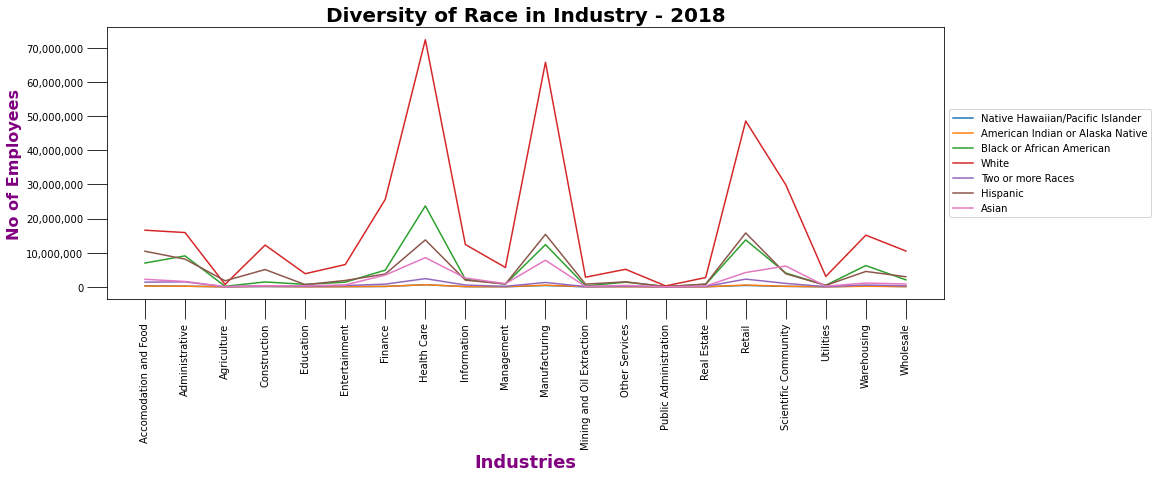

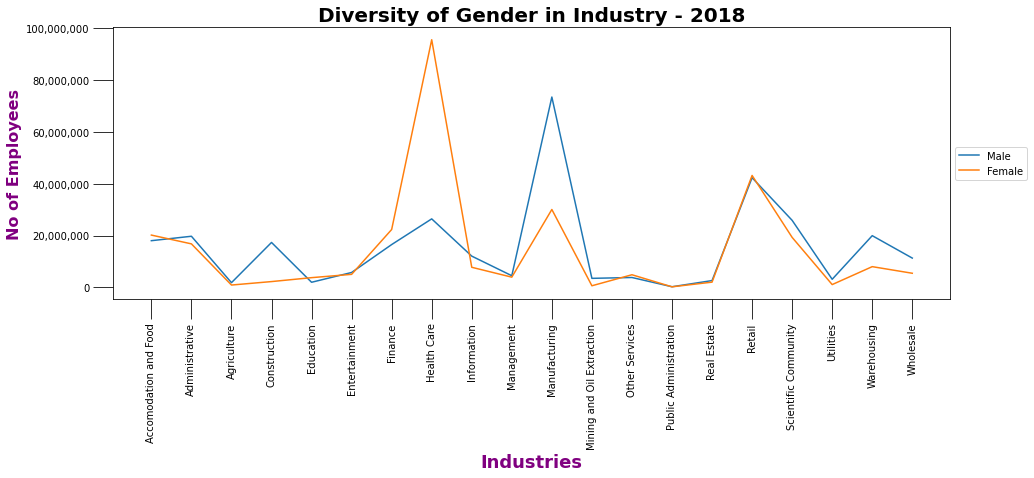

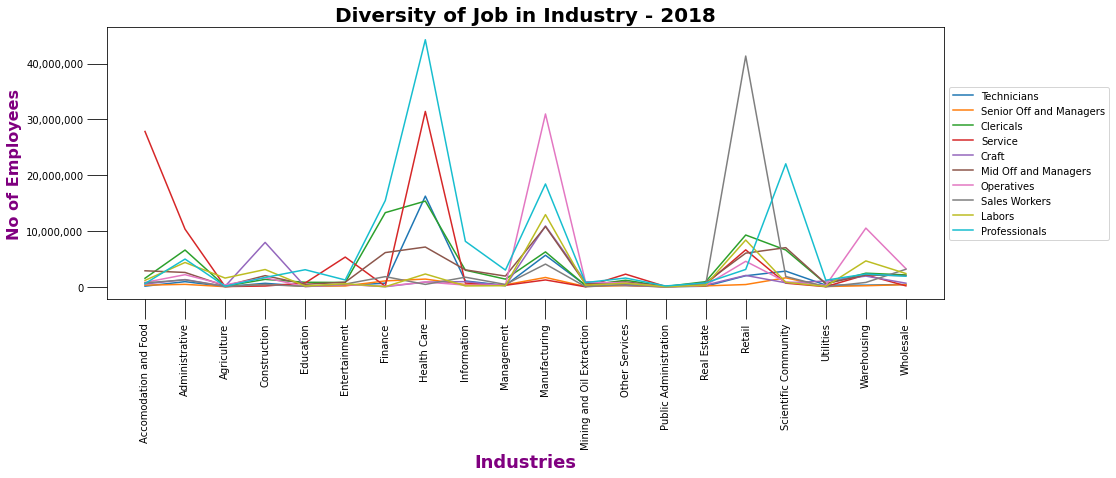

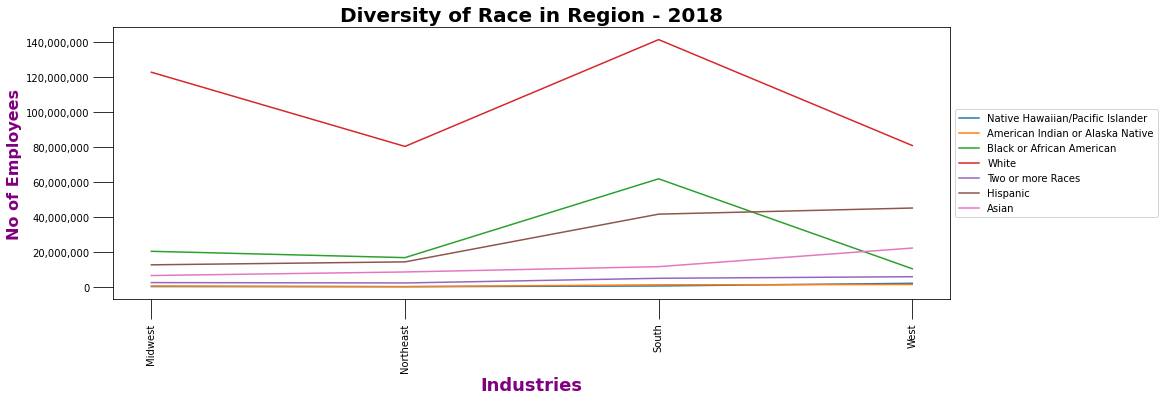

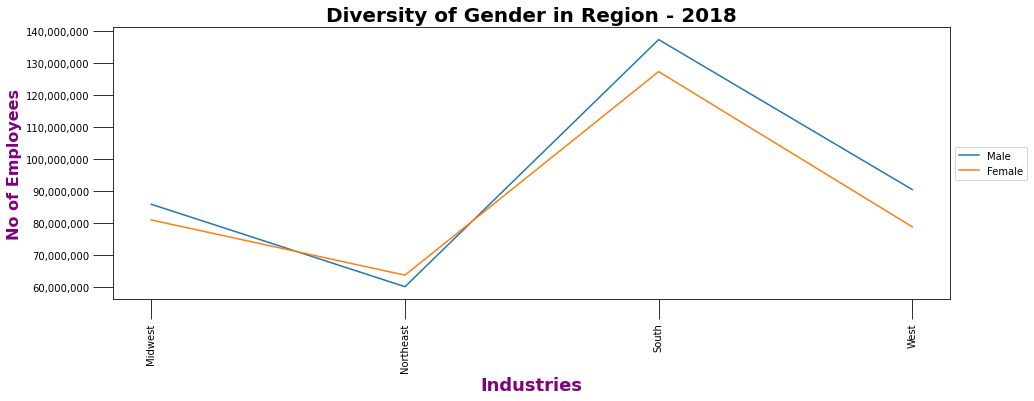

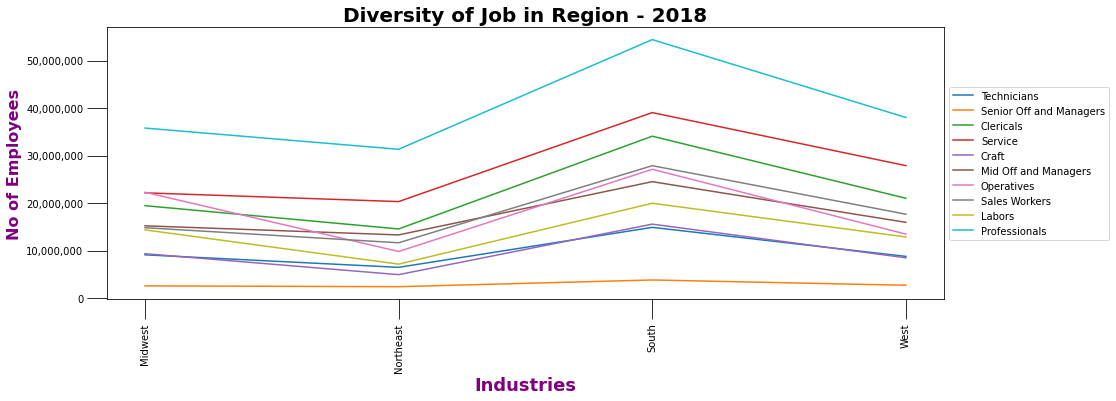

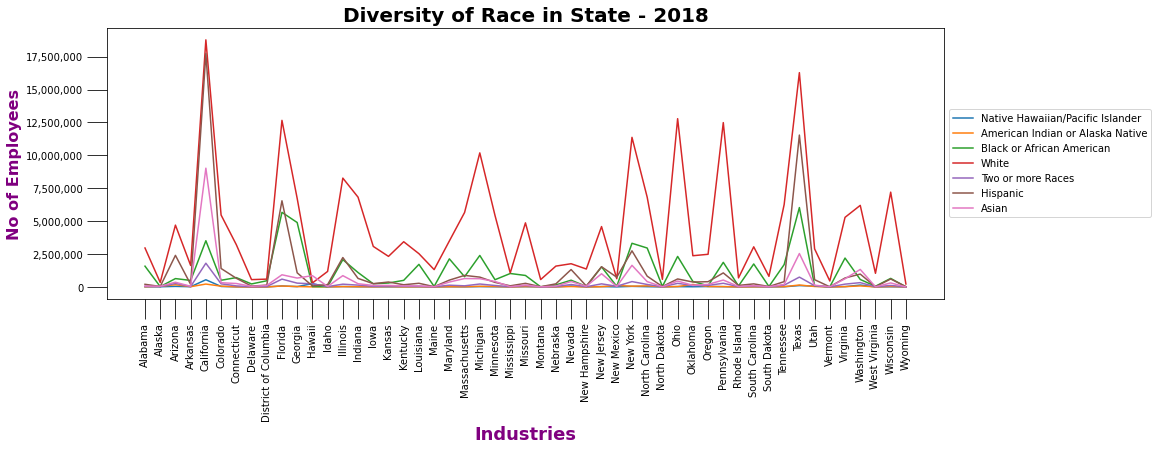

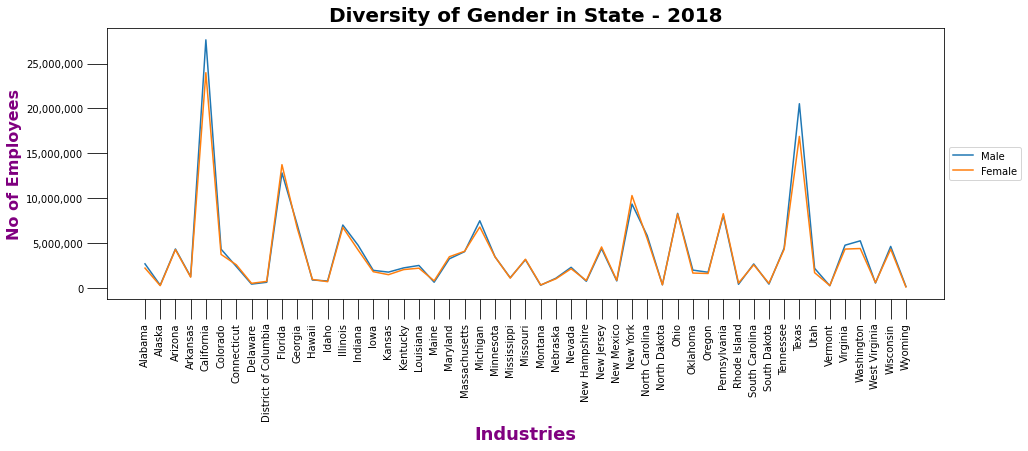

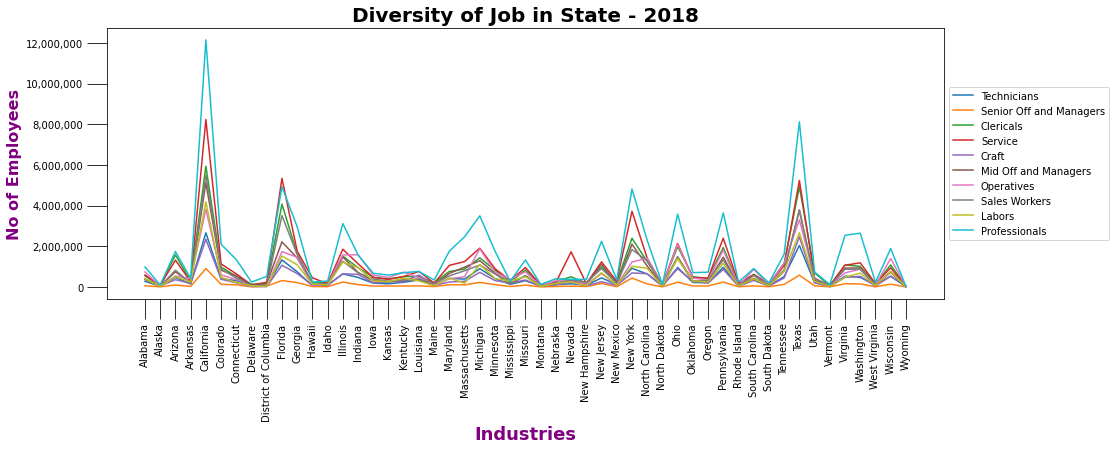

In [6]:
### INDUSTRY/STATE/REGION WISE - RACE, GENDER AND JOB LEVEL Comparison ###

for dataset, EE01_df in EE01_df_dict.items():
    for column_comparision_wise in COMPARISIONS:
        for comparision_element in COMPARISIONS_TYPES:
            if(comparision_element=='Race'):
                column_headers = getColumnHeadersWithParticularLabel(column_mapping, '', 'Aggregate', 'Aggregate')
            elif(comparision_element=='Sex'):
                column_headers = getColumnHeadersWithParticularLabel(column_mapping, 'Aggregate', '', 'Aggregate')
            else:
                column_headers = getColumnHeadersWithParticularLabel(column_mapping, 'Aggregate', 'Aggregate', '')        

            column_headers.append(column_comparision_wise)
            df = getRelevantColumns(EE01_df, column_headers)
            df,column_headers = renameDataFrameMapping(df, column_mapping, comparision_element)
            header_mapping = getHeaderMapping()
            DrawComparisionBetweenColumnsForADataFrame(df, column_headers, column_comparision_wise, 'Diversity of '+header_mapping[comparision_element]+' in '+header_mapping[column_comparision_wise]+' - '+getYearFromDataset(dataset))
            mean_table=df[column_headers].mean()